# Zpětná propagace

Úkolem cvičení je naprogramovat algoritmus zpětné propagace pro obecný případ obdobným způsobem, jako je navržen v knihovně PyTorch.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')  # import tests

import graphviz
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

import ans
from tests import test_backpropagation

V PyTorchi je automatické derivování implementováno v modulu autograd, viz notebook [pytorch-autograd](../notebooks/pytorch-autograd.ipynb). Centrální třída `torch.Tensor` umožňuje nastavit parametr `requires_grad` na hodnotu `True`. PyTorch si v takovém případě zapamatuje všechny operace provedené nad daným tensorem a umí pak sputit zpětnou propagaci gradientu.

My ale tuto funkcionalitu třídy `Tensor` využívat nebudeme a implementujeme si obdobnou zpětnou propagaci vlastními silami. Pro tento účel si zavedeme třídu `Variable`, která bude využívat `Tensor` pouze pro přechovávání dat. Účelem třídy bude pamatovat si operace provedené nad svým tensorem uloženým v atributu `data` a implementovat metodu `backprop()`, která po zavolání uživatelem provede zpětnou propagaci gradientů. Ty se uloží do atributu `grad` objektu třídy `Variable`. Celý systém je tedy velmi podobný tomu, jak autograd funguje v PyTorchi a v podstatě shodný s tím, jak fungoval v původním návrhu knihovny až do verze [0.4.0](https://pytorch.org/blog/pytorch-0_4_0-migration-guide/), kdy došlo ke sloučení tříd `torch.autograd.Variable` a `torch.Tensor`. Přes třídu [Variable](https://docs.chainer.org/en/stable/reference/generated/chainer.Variable.html) "obalující" n-rozměrné pole [cupy.ndarray](https://docs.cupy.dev/en/stable/reference/generated/cupy.ndarray.html) knihovny [cupy](https://cupy.dev/) byl navržen i autograd knihovny [Chainer](https://chainer.org/https://chainer.org/). Chainer byl předchůdcem a významnou inspirací pro PyTorch, který dnes spolu s [TensorFlow](https://www.tensorflow.org/) tvoří dvojici nejpopulárnějších frameworků pro práci s neurosítěmi.

# Třída `Variable`

Třída `Variable` obsahuje atributy
- `data`: `torch.Tensor`, který drží hodnotu proměnné
- `grad`: `torch.Tensor`, který po kompletním provedení zpětné propagace bude obsahovat gradient na proměnnou
- `parents`: `tuple[Variable, ...]`, která odkazuje na přímé předky proměnné
- `grad_fn`: `Callable[[torch.Tensor], tuple[torch.Tensor, ...]]`; odkazuje na zpětný průchod operace, jejíž výsledkem proměnná je

In [3]:
ans.autograd.Variable.__init__??

Vytvořme dvě proměnné `f` a `g`.

In [4]:
f = ans.autograd.Variable(torch.tensor(2.))
f

Variable(2.0, grad_fn=None)

In [5]:
g = ans.autograd.Variable(torch.tensor(3.))
g, g.data

(Variable(3.0, grad_fn=None), tensor(3.))

# Operace sčítání nad objekty typu `Variable`

Pokaždé, kdy se s nějakým objektem typu `Variable` něco stane, tj. sečteme jej či pronásobíme s jinou `Variable`, vznikne nová `Variable` s odpovídajícími atributy. Začněme např. nejjednodušší operací sčítání
$$h = f + g$$
kde `f` a `g` jsou objekty typu `Variable`. Operace sčítání pro `Variable` není definována a prvním úkolem cvičení je jí doplnit.

Proměnná `h` by měla být typu `Variable` a její atributy by měly být
- `data`: `torch.tensor(5.)`, protože `torch.tensor(2.) + torch.tensor(3.) == torch.tensor(5.)`
- `grad`: `None`, protože ještě neproběhla zpětná propagace
- `parents`: `(f, g)`, protože vznikla sečtením `f` a `g`
- `grad_fn`: `def add.backward(dout)`, tedy funkce, která převezme příchozí gradient a provede zpětný průchod operace sčítání.

V Pythonu lze násobení pro uživatelsky definovanou třídu definovat pomocí magické metody `add`. Implementace by mohla vypadat např. takto:
``` python
def add(self, other: 'Variable') -> 'Variable':
    def grad_fn(dout: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        return dout.clone(), dout.clone()
    return Variable(
        self.data + other.data,
        parents=(self, other),
        grad_fn=grad_fn
    )
```
Navracíme `Variable` s atributy
- `data = self.data + other.data`, protože sčítáme,
- `parents = (self, other)`, protože výsledek je potomkem sčítanců `self` a `other`,
- `grad_fn` je funkce definována jako zpětný průchod operace sčítání, pro nějž platí, že parciální derivace na vstupy jsou kopie příchozího gradientu; gradienty vrátí jako `tuple` na všechny své vstupy (zde dva `self` a `other`).

### TODO: doplňte implementaci metody `add` pro sčítání dvou objektů typu `Variable`.

In [6]:
test_backpropagation.TestAdd.eval()

test_operation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_operation) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.032s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [7]:
h = f + g
h

Variable(5.0, grad_fn=Variable.__add__.<locals>.grad_fn)

Rodiče proměnné `h` by měly být `f` a `g`.

In [8]:
h.parents[0] is f, h.parents[1] is g

(True, True)

Funkce `h.grad_fn` nyní odpovídá zpětnému průchodu operace sčítání. Pokud jí zavoláme s nějakým příchozím gradientem, dostaneme propagované gradienty na vstupy, ze kterých sčítáním `h` vzniklo, tj. na proměnné `f` a `g` (v tomto pořadí).

In [9]:
df, dg = h.grad_fn(torch.tensor(1.))
df, dg

(tensor(1.), tensor(1.))

Gradienty `df` a `dg` můžeme zapsat do atributů `f.grad` a `g.grad`, čímž pro takto jednoduchý příklad provedeme kompletní zpětnou propagaci.

In [10]:
f.grad = df
g.grad = df
f.grad, g.grad

(tensor(1.), tensor(1.))

# Odečítání `Variable`

Obdobně můžeme definovat i operaci odečítání. Rozdíl bude pouze ve výpočtu `data` a gradient na druhý operand by měl být přenásoben minus jedničkou (`-dout`).

### TODO: doplňte implementaci metody `__sub__` pro sčítání dvou objektů typu `Variable`.

In [11]:
test_backpropagation.TestSub.eval()

test_operation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_operation) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [12]:
h_ = f - g
h_

Variable(-1.0, grad_fn=Variable.__sub__.<locals>.grad_fn)

# Násobení `Variable`

Zkusme obdobně definovat i pronásobení
$$w = u \cdot v$$
kde `u` a `v` jsou objekty typu `Variable`. Nejprve opět obě proměnné `u` a `v` vytvoříme.

In [13]:
u = ans.autograd.Variable(torch.tensor(2.))
u

Variable(2.0, grad_fn=None)

In [14]:
v = ans.autograd.Variable(torch.tensor(3.))
v

Variable(3.0, grad_fn=None)

Operace násobení není pro `Variable` definována. Doplníme ji obdobným způsobem jako sčítání. V Pythonu se násobení definuje magickou metodou `__mul__`.

### TODO: doplňte implementaci metody `__mul__` pro násobení dvou objektů typu `Variable`.

In [15]:
w = u * v
w

Variable(6.0, grad_fn=Variable.__mul__.<locals>.grad_fn)

In [16]:
test_backpropagation.TestMul.eval()

test_operation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_operation) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

Proveďme zpětnou propagaci.

In [17]:
du, dv = w.grad_fn(1.)
du, dv

(tensor(3.), tensor(2.))

In [18]:
u.grad = du
v.grad = dv
u.grad, v.grad

(tensor(3.), tensor(2.))

Podobně jako u sčítání, nyní je zpětná propagace kompletní, protože proměnné `u` a `v` jsou na počátku výpočetního grafu a nemají žádné předky, tj. jejich `parents` je prázdná `tuple`.

# Výpočetní graf

Pro lepší názornost si operace provedené s `u`, `v` a `w` můžeme vykreslit jako výpočetní graf. Poslouží nám k tomu třída `Digrapgh` balíku `graphviz`. Nejprve vytvoříme objekt grafu.

In [19]:
dot = graphviz.Digraph(graph_attr={'rankdir': 'LR'})

Uzly do grafu přidáme metodou `dot.node(node_uid: str, label: Optional[str] = None, shape: str = 'ellipse')`, kde
- `node_uid` musí být jedinečný název pro uzel v grafu,
- `label` obsahuje textový popis, který se zobrazí ve vykresleném grafu,
- `shape` označuje tvar uzlu - uzly proměnných budeme kreslit jako obdélníky a uzly funkcí jako elipsy.

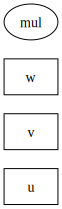

In [20]:
dot.node('u', label='u', shape='record')
dot.node('v', label='v', shape='record')
dot.node('w', label='w', shape='record')
dot.node('mul', label='mul')
dot

Hrany přidáme metodou `dot.edge(from_uid: str, to_uid: str)`, kde
- `from_uid` je jedinečný název uzlu, *ze* kterého hrana povede
- `to_uid` je jedinečný název uzlu, *do* kterého hrana povede

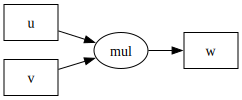

In [21]:
dot.edge('u', 'mul')
dot.edge('v', 'mul')
dot.edge('mul', 'w')
dot

Vykreslení trochu zautomatizujeme a zabalíme do dvou metod. Rozšíříme zároveň popisky (`label`) tak, aby obsahovaly atribud `grad`, pokud není `None`.

In [22]:
def node_label(node: ans.autograd.Variable) -> str:
    try:
        name = next(k for k, v in globals().items() if v is node)
    except StopIteration:
        name = ''
    label = f"{name} = {node.data.item()}"
    if node.grad is not None:
        label += f" | grad = {node.grad.item()}"
    return label

In [23]:
def draw_comp_graph_ex_1() -> graphviz.Digraph:
    dot = graphviz.Digraph(graph_attr={'rankdir': 'LR'})
    dot.node('u', label=node_label(u), shape='record')
    dot.node('v', label=node_label(v), shape='record')
    dot.node('mul', label='mul')
    dot.edge('u', 'mul')
    dot.edge('v', 'mul')
    dot.node('w', label=node_label(w), shape='record')
    dot.edge('mul', 'w')
    return dot

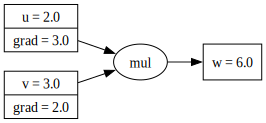

In [24]:
draw_comp_graph_ex_1()

Později ve cvičení vykreslování zobecníme pro libovolné sekvence operací.

# Příklad: $z = (x_1 + a \cdot x_2)^2$

Nyní, když máme definovány základní operace `+`, `-` a `*` a vykreslování, zkusme druhý příklad z notebooku [pytorch-autograd](../notebooks/pytorch-autograd.ipynb)
$$z = (x_1 + a \cdot x_2)^2$$
kde $x_1 = 1$, $a = 2$ a $x_2 = 3$ a tedy $z = (1 + 2 \cdot 3)^2 = 49$.

In [25]:
x1 = ans.autograd.Variable(torch.tensor(1.))
a = ans.autograd.Variable(torch.tensor(2.))
x2 = ans.autograd.Variable(torch.tensor(3.))

x2_ = a * x2
y = x1 + x2_
z = y * y
z

Variable(49.0, grad_fn=Variable.__mul__.<locals>.grad_fn)

In [26]:
x1.data, a.data, x2.data, x2_.data, y.data, z.data

(tensor(1.), tensor(2.), tensor(3.), tensor(6.), tensor(7.), tensor(49.))

In [27]:
def draw_comp_graph_ex_2() -> graphviz.Digraph:
    dot = graphviz.Digraph(graph_attr={'rankdir': 'LR'})
    dot.node('x1', label=node_label(x1), shape='record')
    dot.node('a', label=node_label(a), shape='record')
    dot.node('x2', label=node_label(x2), shape='record')
    dot.node('mul1', label='mul')  # node name must me unique
    dot.edge('a', 'mul1')
    dot.edge('x2', 'mul1')
    dot.node('x2_', label=node_label(x2_), shape='record')
    dot.edge('mul1', 'x2_')
    dot.node('add', label='add')
    dot.edge('x1', 'add')
    dot.edge('x2_', 'add')
    dot.node('y', label=node_label(y), shape='record')
    dot.edge('add', 'y')
    dot.node('mul2', label='mul')
    dot.edge('y', 'mul2')
    dot.edge('y', 'mul2')
    dot.node('z', label=node_label(z), shape='record')
    dot.edge('mul2', 'z')
    return dot

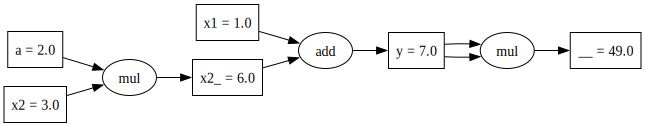

In [28]:
draw_comp_graph_ex_2()

## Zpětná propagace

V druhém příkladu bude zpětná propagace složitější a na více kroků. Začneme opět od konce grafu, tj. tentokrát uzlu `z`.

In [29]:
z.parents

(Variable(7.0, grad_fn=Variable.__add__.<locals>.grad_fn),
 Variable(7.0, grad_fn=Variable.__add__.<locals>.grad_fn))

In [30]:
z.parents[0] is y, z.parents[1] is y

(True, True)

Gradient na `y`:

In [31]:
dy1, dy2 = z.grad_fn(1.)
dy1, dy2

(tensor(7.), tensor(7.))

Vidíme, že jsme dostali gradient na oba vstupy pronásobení `z = y * y`. Protože byl použitý stejný vstup `y` dvakrát, oba gradienty jsou na stejnou proměnnou. V takovém případě gradienty sečteme, viz notebook [pytorch-autograd](../notebooks/pytorch-autograd.ipynb). Analyticky přitom můžeme ověřit, že je výsledek správný
$$\frac{dz}{dy} = 2y = 2 \cdot 7 = 14$$

In [32]:
y.grad = dy1
y.grad += dy2
y.grad

tensor(14.)

Zde je opět názorně vidět, proč je PyTorch navržený tak, aby gradienty při zpětném průchodu nepřepisoval, ale akumuloval. Pokud bychom příchozí gradient přepisovali, celkové `dy` by bylo 7. **Správně bychom tedy vždy při updatu atributu `grad` měli nejprve zjistit, zda je `None` a pokud ano, incializovat ho na nuly, a poté přičíst gradient.**

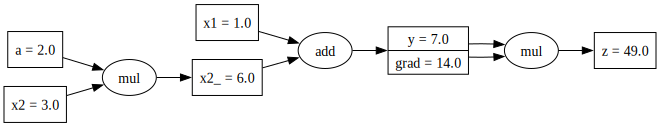

In [33]:
draw_comp_graph_ex_2()

Nyní je třeba "hotový" (kompletně naakumulovaný) gradient `y.grad` propagovat dále do uzlů `x1` a `x2_`. V případě sčítání se gradient při zpětném průchodu pouze rozkopíruje nezměněn do všech vstupů. Potřebujeme pouze z dopředného průchodu vědět, kolik gradientů máme vrátit. Tato informace se uložila při definici funkce `grad_fn` uvnitř `add`.

**Důležitá poznámka:**
- Propagovat gradient z uzlu `y` dále bychom měli až ve chvíli, kdy je "hotový", tj. jsou sečteny příchozí gradienty z větví všech potomků.
- Pokud bychom propagovali dále částečný gradient, např. ihned po přičtení `dy1`, museli bychom se později do `y` opět vrátit a "dopropagovat" zbylou část (`dy2`). Dopracovali bychom se ke správnému výsledku, ovšem pouze za cenu opakovaného volání zpětných průchodů `backward()`, čímž by se výpočet zpomalil a byl neefektivní.
- Zpětná propagace musí volat zpětný průchod každého uzlu právě jednou!

In [34]:
dx1, dx2_ = y.grad_fn(y.grad)
dx1, dx2_

(tensor(14.), tensor(14.))

Akumulujeme gradienty do `x1` a `x2_`.

In [35]:
if x1.grad is None:
    x1.grad = torch.tensor(0.)
x1.grad += dx1
x1.grad

tensor(14.)

In [36]:
if x2_.grad is None:
    x2_.grad = torch.tensor(0.)
x2_.grad += dx2_
x2_.grad

tensor(14.)

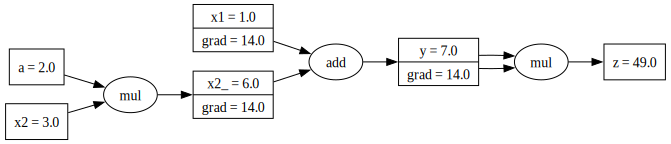

In [37]:
draw_comp_graph_ex_2()

Nyní zbývá poslední krok, kterým je zpětný průchod součinu `x2_ = a * x2`. Pozor: gradienty na vstupy budou vráceny v pořadí, v jakém byly vloženy do dopředného průchodu.

In [38]:
da, dx2 = x2_.grad_fn(x2_.grad)
da, dx2

(tensor(42.), tensor(28.))

In [39]:
if a.grad is None:
    a.grad = torch.tensor(0.)
a.grad += da
a.grad

tensor(42.)

In [40]:
if x2.grad is None:
    x2.grad = torch.tensor(0.)
x2.grad += dx2
x2.grad

tensor(28.)

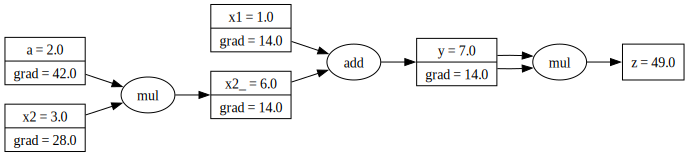

In [41]:
draw_comp_graph_ex_2()

# Příklad: $q = (x^2 + 1)\cdot(x^2 - 1)$

Poslední příklad z notebooku [pytorch-autograd](../notebooks/pytorch-autograd.ipynb)
$$y = x^2$$
$$p = y + 1$$
$$m = y - 1$$
$$q = p \cdot m$$

### TODO: doplňte implementaci metody `__pow__` pro umocňování objektu typu `Variable`.

In [42]:
test_backpropagation.TestPow.eval()

test_powers (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_powers) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.014s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [43]:
x = ans.autograd.Variable(torch.tensor(2.))
s = x ** 2
o = ans.autograd.Variable(torch.tensor(1.))  # can only add Variable + Variable
p = s + o
m = s - o
q = p * m
q

Variable(15.0, grad_fn=Variable.__mul__.<locals>.grad_fn)

In [44]:
x.data, s.data, p.data, m.data, q.data

(tensor(2.), tensor(4.), tensor(5.), tensor(3.), tensor(15.))

In [45]:
def draw_comp_graph_ex_3() -> graphviz.Digraph:
    dot = graphviz.Digraph(graph_attr={'rankdir': 'LR'})
    dot.node('x', label=node_label(x), shape='record')
    dot.node('mul1', label='mul')
    dot.edge('x', 'mul1')
    dot.edge('x', 'mul1')
    dot.node('s', label=node_label(s), shape='record')
    dot.edge('mul1', 's')
    dot.node('o', label=node_label(o), shape='record')
    dot.node('add', label='add')
    dot.edge('s', 'add')
    dot.edge('o', 'add')
    dot.node('p', label=node_label(p), shape='record')
    dot.edge('add', 'p')
    dot.node('sub', label='sub')
    dot.edge('s', 'sub')
    dot.edge('o', 'sub')
    dot.node('m', label=node_label(m), shape='record')
    dot.edge('sub', 'm')
    dot.node('mul2', label='mul')
    dot.edge('p', 'mul2')
    dot.edge('m', 'mul2')
    dot.node('q', label=node_label(q), shape='record')
    dot.edge('mul2', 'q')
    return dot

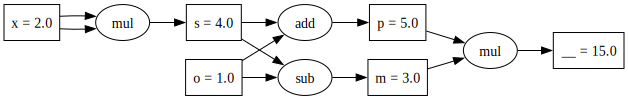

In [46]:
draw_comp_graph_ex_3()

## Topologické řazení uzlů

Mohli bychom postupovat stejně jako předchozí dva příklady. Pomocí `q.grad_fn` (zpětný průchod násobení)) bychom spočítali nejprve `dp` a `dm` a poté bychom se vydali jednou z těchto dvou větví. Zde ovšem kvůli diamantové struktuře grafu nastává problém, kde se na cestě větví zastavit. Pokud si např. vybereme větev `p` a budeme rekurzivně pokračovat, dokud to jde, dostaneme se až k `x`. Až teprve poté by na řadu přišla větev `m`, odkud bychom opět rekurzivně dokráčeli až k `x`. V uzlu `s` bychom ale volali `s.grad_fn` z každé větve, tj. dohromady dvakrát. To sice pro takto jednoduchý graf nezpůsobí větší problémy, pro složitější grafy jako např. rekurentní neurosítě by však došlo k výraznému zpomalení oproti optimální implementaci.

Jak bylo uvedeno výše, **každá `grad_fn` by měla být zavolána právě jednou**. Docílit toho lze tak, že zpětný průchod `node.grad_fn(node.grad)` každého uzlu `node` budeme volat až potom, co jeho odpovídající `node.grad` je kompletně akumulovaný ze všech potomčích větví. Uzly ve správném pořadí zajistí tzv. topologické třídění. Topologické třídění je taková posloupnost uzlů, kdy pro každou hranu $(u, v)$ vedoucí z uzlu $u$ do uzlu $v$ platí, že $u$ se v posloupnosti nachází před $v$, viz [https://en.wikipedia.org/wiki/Topological_sorting](https://en.wikipedia.org/wiki/Topological_sorting).

Topologické třídění tedy zařídí, že uzly dostaneme v pořadí, v jakém na sobě vzájemně zavisejí *v dopředném průchodu*. Jelikož uzly jsou v našem případě objekty `Variable`, topologicky sežazená posloupnost bude `list[ans.autograd.Variable]`. Konkrétně ve 3. příkladě to může být `[x, s, p, m, q]`. Pokud poté *ve zpětném průchodu* budeme volat `node.grad_fn(node.grad)` a akumulaci gradientů *v opačném pořadí*, tj. `for node in [q, m, p, s, x]`, nemůže se nám stát, ze `node.grad` nebude zcela kompletně nasčítaný. Prvním krokem a úkolem cvičení je tedy implementace topologického třídění uzlů v metodě `Variable.predecessors()`.

### TODO: implementujte funkci `Variable.predecessors()` v modulu `ans.autograd`.

In [47]:
test_backpropagation.TestTopologicalSort.eval()

test_examples (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_examples) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [48]:
variables_sorted = q.predecessors()
variables_sorted

[Variable(2.0, grad_fn=None),
 Variable(4.0, grad_fn=Variable.__pow__.<locals>.grad_fn),
 Variable(1.0, grad_fn=None),
 Variable(5.0, grad_fn=Variable.__add__.<locals>.grad_fn),
 Variable(3.0, grad_fn=Variable.__sub__.<locals>.grad_fn),
 Variable(15.0, grad_fn=Variable.__mul__.<locals>.grad_fn)]

## Obecná zpětná propagace

Nyní můžeme projít seznam `variables_sorted` *v opačném pořadí* a:
- zavolat zpětný průchod daného uzlu,
- získané gradienty akumulovat do atributu `grad` přímých rodičů uzlu.
Celý takovýto postup pak tvoří obecný algoritmus zpětné propagace. Implementovat ho bude metoda `backprop()` třídy `Variable` a měla by tak být ekvivalentem metody `torch.Tensor.backward()`. Pokud např. zavoláme `q.backprop()`, funkce vyplní u všech proměnných `x`, `s`, `o`, `p`, `m` a `q` jejich atribud `grad`, jehož hodnota bude odpovídat parciální derivaci $dq/d\cdot$, kde $\cdot$ značí uzly `x` až `q`.

### TODO: implementujte metodu `backprop()` třídy `Variable`.

In [49]:
test_backpropagation.TestBackprop.eval()

test_examples (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_examples) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.011s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [50]:
q.backprop()

In [51]:
x.grad, s.grad, o.grad, p.grad, m.grad, q.grad

(tensor(32.), tensor(8.), tensor(-2.), tensor(3.), tensor(5.), tensor(1.))

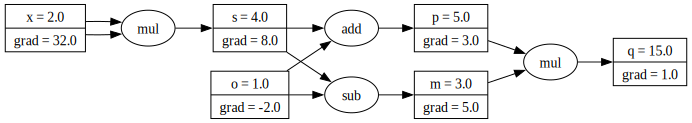

In [52]:
draw_comp_graph_ex_3()

# Funkce pro vykreslování grafu

Topologické řazení `Variable.predecessors()` využijeme i pro vykreslování obecného grafu. Funkce je připravena ve třídě `Variable` jako
``` python
def to_graphviz(self, show_data: bool = False) -> graphviz.Digraph:
    dot = graphviz.Digraph(graph_attr={'rankdir': 'LR'})
    ...
    return dot
```
Podobně jako funkce `draw_comp_graph_ex_{i}` vrací objekt typu `graphviz.Digraph`, který se v notebooku vykreslí jako graf. Úkolem je chybějící implementaci doplnit. Vykreslení výrazně usnadní dvě připravené funkce
``` python
def get_node_info(node: 'Variable', default: str = '', show_data: bool = False) -> tuple[str, str]:
    ...

def get_func_info(node: 'Variable') -> tuple[str, str]:
    ...
```
Obě funkce přijímají `Variable` jako uzel grafu a vrátí pro něj odpovídající jedinečný identifikátor a zároveň popisek, který se zobrazí při vykreslení - podobně jako funkce tohoto notebooku `node_label(node: ans.autograd.Variable) -> str`.
- Pokud do grafu přidáváme uzel reprezentovaný proměnnou `node`, použijeme
``` python
node_uid, node_label = get_node_info(node)
dot.node(node_uid, label=node_label, shape='record')
```
- V případě uzlu, který značí funkci, použijeme obdobným způsobem funkci `get_func_info()`. Funkce převezme `node: Variable` a z `node.grad_fn` zjistí název funkce, který se pak může vykreslit jako popisek do grafu.

### TODO: implenetujte funkci `Variable.to_graphviz()` modulu `ans.autograd`.

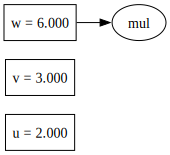

In [53]:
w.to_graphviz()

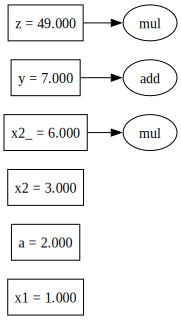

In [54]:
z.to_graphviz()

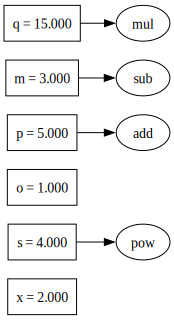

In [55]:
q.to_graphviz()

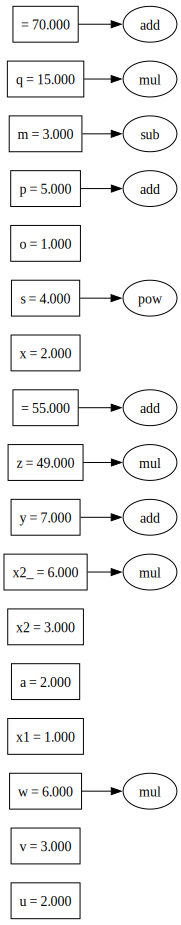

In [56]:
(w + z + q).to_graphviz()